In [1]:
# ---- 1-1 Libraries for Path and Logging ----
import os
import sys
import typer
from tqdm import tqdm
from pathlib import Path
from loguru import logger
ADDR_ROOT = Path("/root/LHAI")
ADDR_CODE = ADDR_ROOT / "codes"   # 你的 codes 目录
sys.path.append(str(ADDR_ROOT))
sys.path.append(str(ADDR_CODE))

logger.success(f"ADDR_ROOT set to: {ADDR_ROOT}")
logger.success(f"ADDR_CODE  set to: {ADDR_CODE}")

# ---- 1-2 Libraries for Configuration and Modules ----
from codes.function.Log import log
import codes.function.Train as Train
import codes.function.Loss as lossfunction
from codes.config.config_DDPM import EvalConfig
from codes.config.config_DDPM import ModelConfig
from codes.function.Dataset import ImageDataset, DataModule
# ---- 1-3 PyTorch ----
import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split, ConcatDataset
# ---- 1-4 Others ----
import scipy
import importlib
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import deeplay as dl
# ---- 1-5 eval ----
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure as MS_SSIM
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.image import PeakSignalNoiseRatio as PSNR
from torchmetrics.regression import MeanAbsoluteError as MAE

2025-09-12 13:44:48.606 | SUCCESS  | __main__:<module>:13 - ADDR_ROOT set to: /root/LHAI
2025-09-12 13:44:48.607 | SUCCESS  | __main__:<module>:14 - ADDR_CODE  set to: /root/LHAI/codes


In [2]:
# ---- 0. 配置与设备 ----
eval_cfg = EvalConfig()
model_cfg = ModelConfig()

# 用传参覆盖默认
exp_name = eval_cfg.exp_name
# data_dir = eval_cfg.data_dir
data_dir = Path("/root/autodl-fs")
data_name = eval_cfg.data_name
model_name_diffusion = eval_cfg.model_name_diffusion
model_name_unet = eval_cfg.model_name_unet
model_dir =  eval_cfg.model_dir
seed = eval_cfg.seed
frac = eval_cfg.frac
epochs = eval_cfg.epochs
batch_size = eval_cfg.batch_size
lr_max = eval_cfg.lr_max
lr_min = eval_cfg.lr_min
datarange = eval_cfg.datarange
LoB = eval_cfg.LoB
dataname = eval_cfg.dataname

data_path = data_dir / data_name
model_path = model_dir / f"{model_name_diffusion}.py"
model_weight_name = "Last_DDPM_EXP01_1000epo_32bth_xingwei.pth"
model_weight_dir = Path("/root/LHAI/saves/MODEL/DDPM")
model_weight_path = model_weight_dir / model_weight_name

torch.manual_seed(seed)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

logger.success("========= 2-1 参数加载完成 =========")

2025-09-12 13:44:52.002 | SUCCESS  | __main__:<module>:32 - ========= 2-1 参数加载完成 =========


In [3]:
# ==== 2-2 Data: trainloader & testloader ====
dm = DataModule(
data_path=data_path,
batch_size=batch_size,
frac=frac,
inverse=False,
shuffle_train=False,
shuffle_test=False,
num_workers=0,
pin_memory=False,
drop_last=False,
)

trainloader, testloader = dm.build()

for batch_idx, (blurry_img, original_img) in enumerate(trainloader):
    if batch_idx == 0:
        blurry_img_shape = blurry_img.shape  # 示例：(32, 1, 64, 64)
        original_img_shape = original_img.shape
        blurry_img_numpy = blurry_img[1].squeeze().detach().cpu().numpy()
        blurry_img_min = blurry_img_numpy.min()
        blurry_img_max = blurry_img_numpy.max()
        blurry_img_sample = blurry_img_numpy
        break

logger.info(f"""
====================== 数据参数 ======================
Output of data from Batch 1

- blurry image     : {blurry_img_shape} [批次, 通道数, 高度, 宽度]
- clear image      : {original_img_shape} [批次, 通道数, 高度, 宽度]
- datarange        : 最小值 = {blurry_img_min:.6f}, 最大值 = {blurry_img_max:.6f}
- 1st image output :

{np.array2string(blurry_img_sample, precision=4, suppress_small=True, threshold=64)}
===============================================================
""")

logger.success("========= 2-2 数据加载完成 =========")

2025-09-12 13:44:54.304 | INFO     | __main__:<module>:26 - 
====================== 数据参数 ======================
Output of data from Batch 1

- blurry image     : torch.Size([32, 1, 64, 64]) [批次, 通道数, 高度, 宽度]
- clear image      : torch.Size([32, 1, 64, 64]) [批次, 通道数, 高度, 宽度]
- datarange        : 最小值 = 0.000000, 最大值 = 1.000000
- 1st image output :

[[0.     0.0007 0.0012 ... 0.0185 0.0144 0.0135]
 [0.0014 0.0003 0.0013 ... 0.0175 0.0137 0.0134]
 [0.0012 0.0017 0.0009 ... 0.021  0.0165 0.016 ]
 ...
 [0.0745 0.0823 0.0935 ... 0.0226 0.0238 0.0223]
 [0.0587 0.0664 0.0712 ... 0.0196 0.0187 0.0189]
 [0.0415 0.0474 0.0489 ... 0.0169 0.0152 0.0159]]

2025-09-12 13:44:54.306 | SUCCESS  | __main__:<module>:39 - ========= 2-2 数据加载完成 =========


In [4]:
# ==== 2-3 Initialize the model ====
# DIFFUSION
model_params = model_cfg.model_params
params_diffusion = model_params[model_name_diffusion]
params_unet = model_params[model_name_unet]

sys.path.append(str(model_dir))
module_diffusion = importlib.import_module(model_name_diffusion)
DIFFUSION = getattr(module_diffusion, model_name_diffusion)

diffusion = DIFFUSION(**params_diffusion)

# Unet
model_params = model_cfg.model_params
params_unet = model_params[model_name_unet]
sys.path.append(str(model_dir))
module_unet = importlib.import_module(model_name_unet)
UNET = getattr(module_unet, model_name_unet)

unet = UNET(**params_unet).to(device)
unet.build()
unet.to(device)

# 加载权重
unet.load_state_dict(torch.load(model_weight_path, map_location=device))

# loss
trainingloss = lossfunction.msejsloss

logger.success(f"========= 2-3 模型、模型参数与loss加载完成 =========")

/tmp/ipykernel_7681/3444785926.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(model_weight_path, map_location=device))
2025-09-12 13:44

In [5]:
# ==== 2-4 Evaluation ====

# save path
dataname = data_name.split("_")[0]
save_dir_eval = ADDR_ROOT / "saves" / "EVAL" / model_name_diffusion
if not os.path.exists(save_dir_eval):
    os.makedirs(save_dir_eval)

# logger output
format_model_params = Train.format_model_params
torch.set_printoptions(precision=10)
train_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
gpu_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device"
loss_name = trainingloss.__name__
model_params_str_diffusion = format_model_params(model_params[model_name_diffusion])
model_params_str_unet = format_model_params(model_params[model_name_unet])
filetmp = np.load(data_path, allow_pickle=True)
filelen = int(filetmp.shape[0])
del filetmp
train_msg = f"""
====================== 评估参数 ======================
🔧 配置信息概览：
- traintime               : {train_time}
- exp_name                : {exp_name}
- model_name              : {model_name_diffusion} + {model_name_unet}
- data_name               : {data_name}（{dataname}）
- model_path              : {model_path}
- data_path               : {data_path}
- seed                    : {seed}
- frac                    : 训练集 {frac*100:.1f}% / 测试集 {100-frac*100:.1f}%
- datalength              : {filelen}
- epochs                  : {epochs}
- batch_size              : {batch_size}
- datarange               : {datarange}
- learnrate               : 最小 = {lr_min:.1e}, 最大 = {lr_max:.1e}
- lossname                : {loss_name}
- device                  : {device}({gpu_name})
- model_params_diffusion  : 

{model_params_str_diffusion}
- model_params_unet       :

{model_params_str_unet}
==============================================================
"""
logger.info(train_msg)

2025-09-12 13:44:55.124 | INFO     | __main__:<module>:46 - 
====================== 评估参数 ======================
🔧 配置信息概览：
- traintime               : 2025-09-12 13:44:54
- exp_name                : EXP01
- model_name              : DDPM + UNET
- data_name               : xingwei_10000_64_train_v1.npy（xingwei）
- model_path              : /root/LHAI/codes/models/DDPM.py
- data_path               : /root/autodl-fs/xingwei_10000_64_train_v1.npy
- seed                    : 0
- frac                    : 训练集 80.0% / 测试集 20.0%
- datalength              : 10000
- epochs                  : 2
- batch_size              : 32
- datarange               : 1.0
- learnrate               : 最小 = 5.0e-06, 最大 = 5.0e-04
- lossname                : msejsloss
- device                  : cuda:0(NVIDIA GeForce RTX 4090)
- model_params_diffusion  : 

        • noise_steps : 2000
        • beta_start  : 0.0001
        • beta_end    : 0.02
        • img_size    : 64
        • device      : None
        • pos_emb_di

Sampling: 100%|██████████| 2000/2000 [00:04<00:00, 479.88it/s]
/tmp/ipykernel_7681/131652214.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
2025-09-12 13:45:03.760 | SUCCESS  | __main__:<module>:121 - Evaluation 1: Loss figure saved at /root/LHAI/saves/EVAL/DDPM/Eval_distribution_Last_DDPM_EXP01_1000epo_32bth_xingwei.pth.png
2025-09-12 13:45:03.762 | SUCCESS  | __main__:<module>:122 - ========= 2-4-2 lineprofiles and resmap 评估完成 =========


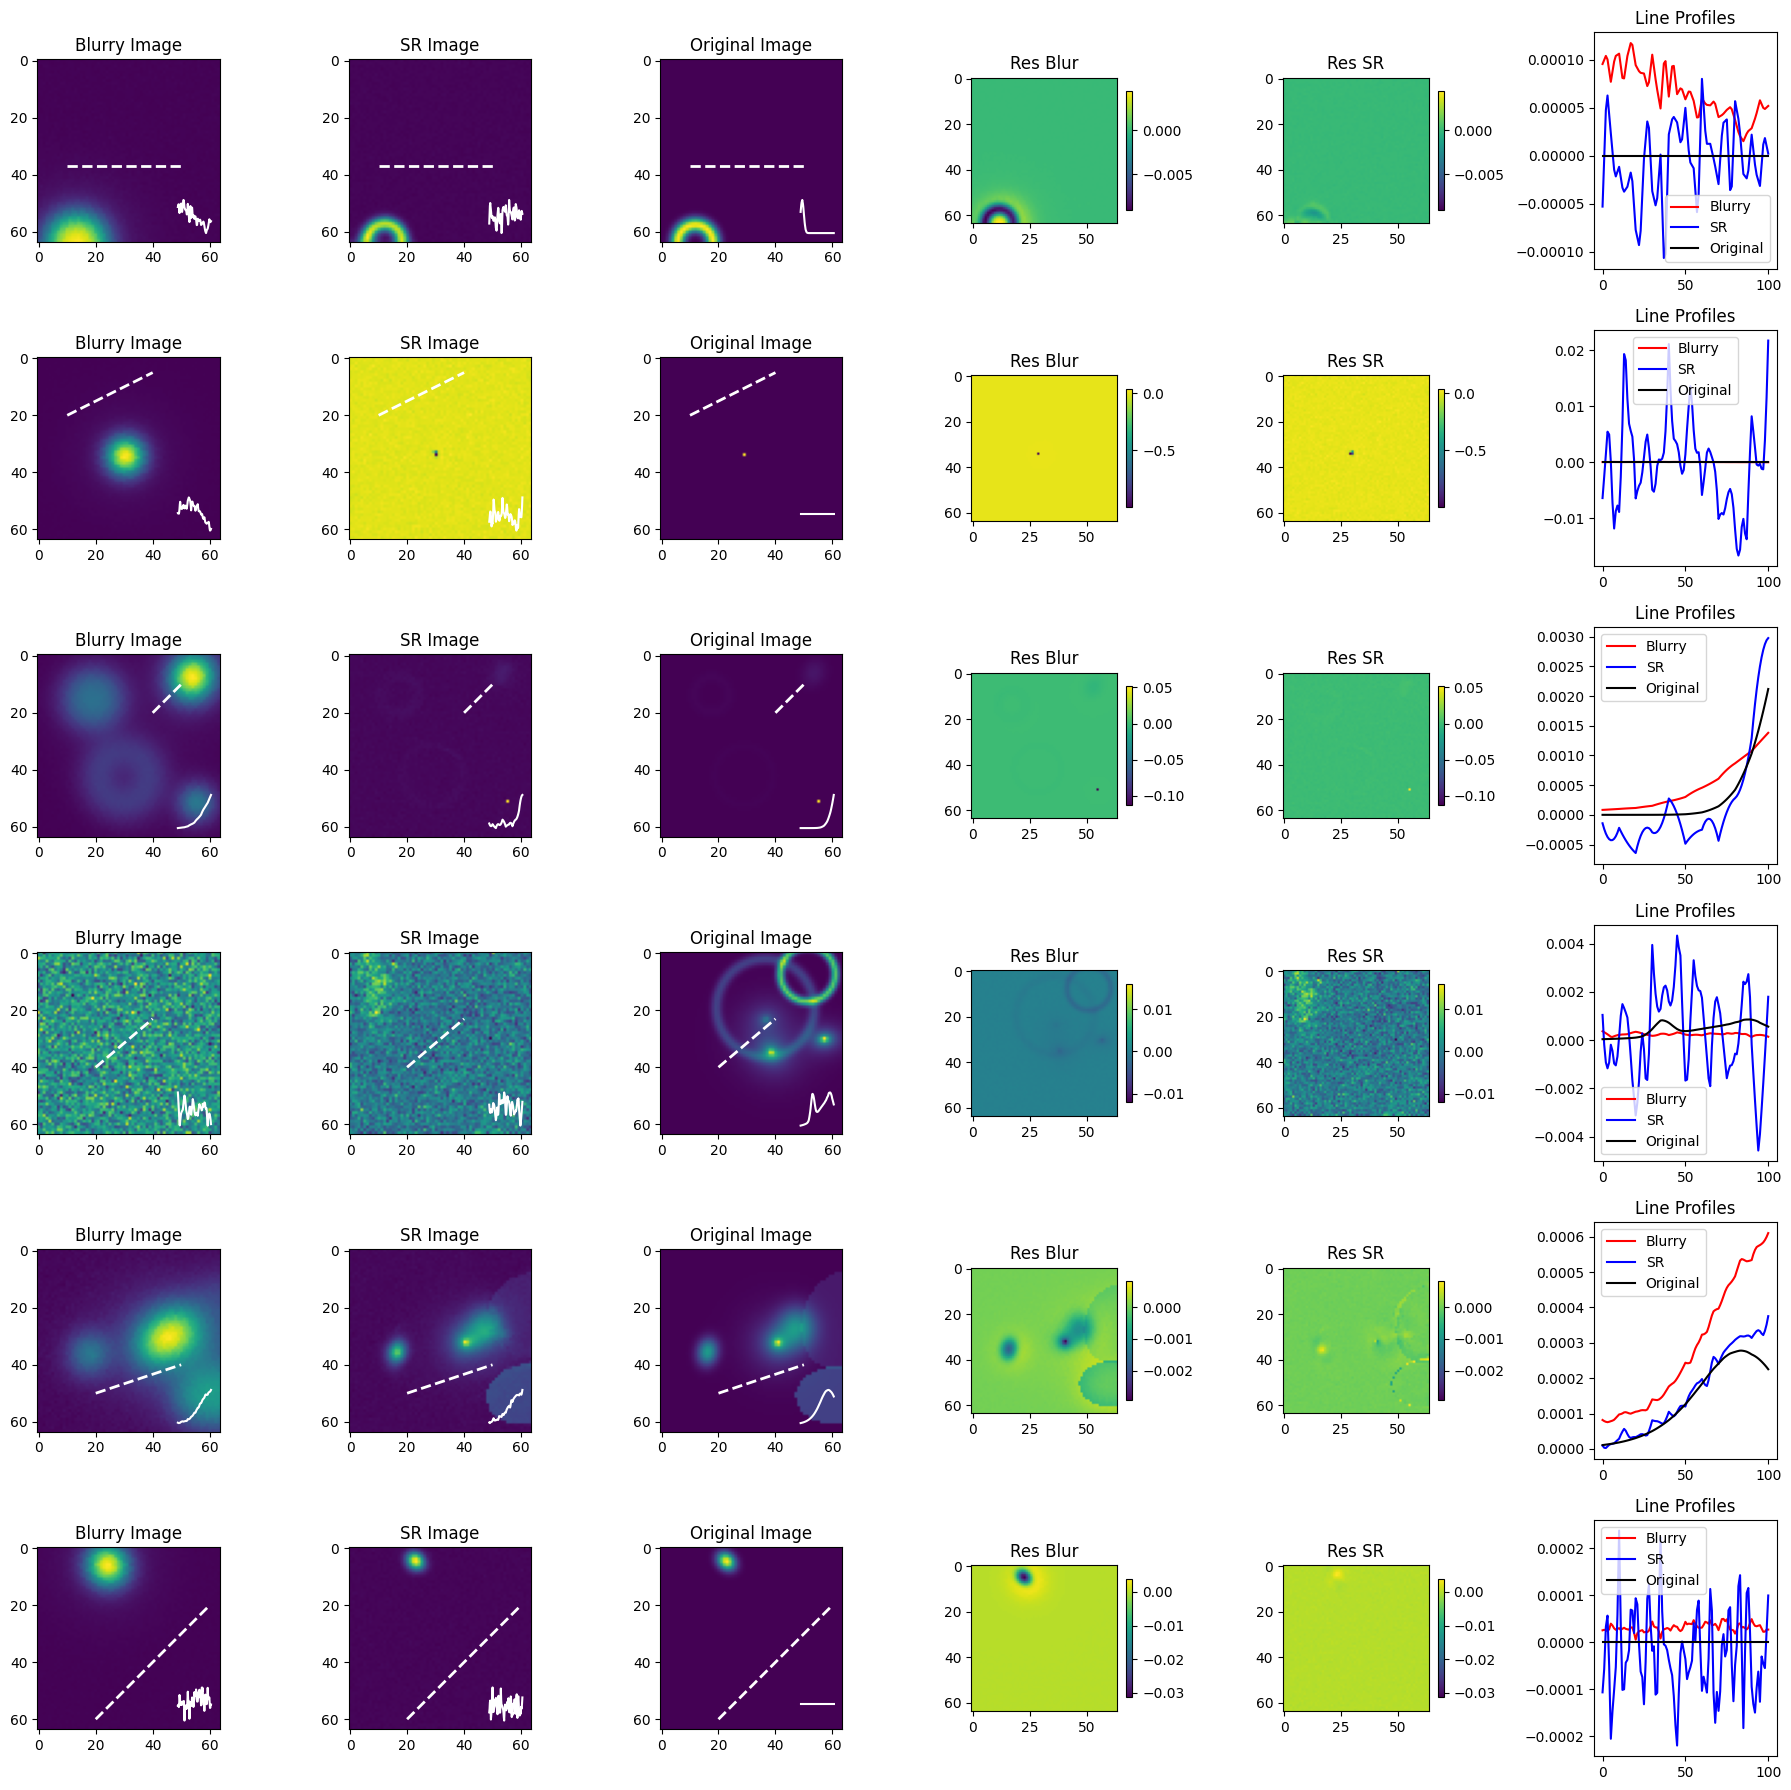

In [6]:
# ---- 2-4 evaluation 2: lineprofiles and resmap----
def interp2d(x1,x2,y1,y2,arr):
    x = np.arange(arr.shape[0])
    y = np.arange(arr.shape[0])
    xx,yy = np.meshgrid(x,y)
    interpolate = scipy.interpolate.RegularGridInterpolator((x,y),arr)
    y_t = np.linspace(x1,x2,101)
    x_t = np.linspace(y1,y2,101)
    z_t = interpolate((x_t,y_t))
    return z_t

# 获取测试集中的第一批图像
test_input_images, test_target_images = next(iter(testloader))
test_input_images = test_input_images.to(device)
test_target_images = test_target_images.to(device)

n_images = 10 # 显示前n张图像

# 推理（生成高分辨图像序列）
with torch.no_grad():
    generated_images = diffusion.reverse_diffusion(
        model=unet,
        n_images=n_images,
        n_channels=1,
        input_image=test_input_images[:n_images],
        save_time_steps=None
    )

# 转置维度，从 (T, B, C, H, W) → (B, T, C, H, W)
generated_images = generated_images.swapaxes(0, 1)

showlist = [0,1,2,3,4,5]# 你可以改这个，展示哪几张图
num_images_to_show = len(showlist)
xys = np.zeros(num_images_to_show).tolist()
for i in range(num_images_to_show):
    xys[i] = [0,0,0,0]
xys[0] = [10, 50, 37, 37]
xys[1] = [10, 40, 20, 5]
xys[2] = [40, 50, 20, 10]
xys[3] = [20, 40, 40, 23]
xys[4] = [20, 50, 50, 40]
xys[5] = [20, 60, 60, 20]

# 提取图像：低分辨图 / 生成图 / 原始图
img_LR = test_input_images.cpu()
img_HR = test_target_images.cpu()

fig, axes = plt.subplots(num_images_to_show, 6, figsize=(18, 3 * num_images_to_show))

for i in range(num_images_to_show):
    count = showlist[i]
    x1, x2, y1, y2 = xys[i]
    color = 'white'

    # 提取图像
    blurry_img_numpy = img_LR[count].squeeze().numpy()
    original_img_numpy = img_HR[count].squeeze().numpy()

    image_diff_trajectory = generated_images[:, count]
    sr_img_numpy = image_diff_trajectory[-1].cpu()
    sr_img_numpy = sr_img_numpy.squeeze().numpy()

    # 归一化（可选）
    blurry_img_numpy = blurry_img_numpy / blurry_img_numpy.sum()
    sr_img_numpy = sr_img_numpy / sr_img_numpy.sum()
    original_img_numpy = original_img_numpy / original_img_numpy.sum()

    # Blurry 图像
    axes[i, 0].imshow(blurry_img_numpy, cmap='viridis')
    axes[i, 0].set_title('Blurry Image')
    axes[i, 0].plot([x1, x2], [y1, y2], linestyle='--', color=color, linewidth=2)
    axins = inset_axes(axes[i, 0], width="20%", height="20%", loc=4)
    axins.axis('off')
    axins.patch.set_alpha(0)
    axins.plot(interp2d(x1, x2, y1, y2, blurry_img_numpy), color=color)

    # SR 图像
    axes[i, 1].imshow(sr_img_numpy, cmap='viridis')
    axes[i, 1].set_title('SR Image')
    axes[i, 1].plot([x1, x2], [y1, y2], linestyle='--', color=color, linewidth=2)
    axins = inset_axes(axes[i, 1], width="20%", height="20%", loc=4)
    axins.axis('off')
    axins.patch.set_alpha(0)
    axins.plot(interp2d(x1, x2, y1, y2, sr_img_numpy), color=color)

    # 原始 HR 图像
    axes[i, 2].imshow(original_img_numpy, cmap='viridis')
    axes[i, 2].set_title('Original Image')
    axes[i, 2].plot([x1, x2], [y1, y2], linestyle='--', color=color, linewidth=2)
    axins = inset_axes(axes[i, 2], width="20%", height="20%", loc=4)
    axins.axis('off')
    axins.patch.set_alpha(0)
    axins.plot(interp2d(x1, x2, y1, y2, original_img_numpy), color=color)

    # 残差图
    res_blur = blurry_img_numpy - original_img_numpy
    res_sr = sr_img_numpy - original_img_numpy
    vmin = min(res_blur.min(), res_sr.min())
    vmax = max(res_blur.max(), res_sr.max())

    im3 = axes[i, 3].imshow(res_blur, vmin=vmin, vmax=vmax, cmap='viridis')
    axes[i, 3].set_title('Res Blur')
    fig.colorbar(im3, ax=axes[i, 3], shrink=0.5)

    im4 = axes[i, 4].imshow(res_sr, vmin=vmin, vmax=vmax, cmap='viridis')
    axes[i, 4].set_title('Res SR')
    fig.colorbar(im4, ax=axes[i, 4], shrink=0.5)

    # 曲线图
    axes[i, 5].plot(interp2d(x1, x2, y1, y2, blurry_img_numpy), color='red', label='Blurry')
    axes[i, 5].plot(interp2d(x1, x2, y1, y2, sr_img_numpy), color='blue', label='SR')
    axes[i, 5].plot(interp2d(x1, x2, y1, y2, original_img_numpy), color='black', label='Original')
    axes[i, 5].set_title('Line Profiles')
    axes[i, 5].legend()

plt.tight_layout()
savepath = f'{ADDR_ROOT}/saves'
savefigname = f"Eval_distribution_{model_weight_name}"
savefig2_path = f'{save_dir_eval}/{savefigname}.png'
plt.savefig(savefig2_path, dpi=300)
logger.success(f"Evaluation 1: Loss figure saved at {savefig2_path}")
logger.success("========= 2-4-2 lineprofiles and resmap 评估完成 =========")

In [7]:
# ---- 2-4 evaluation 4: NRMSE,MAE,MS-SSIM,SSIM,PSNR ----
ms_ssim_metric = MS_SSIM(
    data_range=2.0, kernel_size=7, betas=(0.0448, 0.2856, 0.3001)
).to(device)
ssim_metric = SSIM(data_range=2.0).to(device)
psnr_metric = PSNR(data_range=2.0).to(device)
mae_metric = MAE().to(device)

# 你已有的测试输入图像
all_inputs = []
all_targets = []
for inputs, targets in testloader:
    all_inputs.append(inputs)
    all_targets.append(targets)
test_input_images  = torch.cat(all_inputs, dim=0).to(device)
test_target_images = torch.cat(all_targets, dim=0).to(device)

n_images = 2000

# 推理生成高分辨图像序列
with torch.no_grad():
    generated_images = diffusion.reverse_diffusion(
        model=unet,
        n_images=n_images,
        n_channels=1,
        input_image=test_input_images[:n_images],
        save_time_steps=None
    )

# 转置维度 (T, B, C, H, W) → (B, T, C, H, W)
generated_images = generated_images.unsqueeze(0)

# 存储每张图像的评估指标
nrmse_list, mae_list, ms_ssim_list, ssim_list, psnr_list = [], [], [], [], []
nrmse_ipt_list, mae_ipt_list, ms_ssim_ipt_list, ssim_ipt_list, psnr_ipt_list = [], [], [], [], []

for i in range(n_images):
    image_diff_trajectory = generated_images[:, i]  # shape: (T, C, H, W)
    generated_high_res_image = image_diff_trajectory[-1]  # 最后一帧
    target_high_res_image = test_target_images[i]
    input_low_res_image = test_input_images[i]

    # 将图像转到 CPU
    gen_img = generated_high_res_image.cpu()
    tgt_img = target_high_res_image.cpu()
    ipt_img = input_low_res_image.cpu()

    # diff = tgt_img - ipt_img
    # diff = tgt_img - gen_img
    # np.save(f'diff_gen{i}.npy',diff)

    # 指标计算 -- gen
    mae = torch.mean(torch.abs(gen_img - tgt_img)).item()
    nrmse = torch.sqrt(torch.mean((gen_img - tgt_img) ** 2)) / (tgt_img.max() - tgt_img.min())
    nrmse = nrmse.item()

    mae_list.append(mae)
    nrmse_list.append(nrmse)

    ms_ssim_val = ms_ssim_metric(gen_img.unsqueeze(0), tgt_img.unsqueeze(0)).item()
    ssim_val    = ssim_metric(gen_img.unsqueeze(0), tgt_img.unsqueeze(0)).item()
    psnr_val    = psnr_metric(gen_img.unsqueeze(0), tgt_img.unsqueeze(0)).item()

    ms_ssim_list.append(ms_ssim_val)
    ssim_list.append(ssim_val)
    psnr_list.append(psnr_val)

    # 指标计算 -- input
    mae_ipt = torch.mean(torch.abs(ipt_img - tgt_img)).item()
    nrmse_ipt = torch.sqrt(torch.mean((ipt_img - tgt_img) ** 2)) / (tgt_img.max() - tgt_img.min())
    nrmse_ipt = nrmse_ipt.item()

    mae_ipt_list.append(mae_ipt)
    nrmse_ipt_list.append(nrmse_ipt)

    ms_ssim_ipt_val = ms_ssim_metric(ipt_img.unsqueeze(0), tgt_img.unsqueeze(0)).item()
    ssim_ipt_val    = ssim_metric(ipt_img.unsqueeze(0), tgt_img.unsqueeze(0)).item()
    psnr_ipt_val    = psnr_metric(ipt_img.unsqueeze(0), tgt_img.unsqueeze(0)).item()

    ms_ssim_ipt_list.append(ms_ssim_ipt_val)
    ssim_ipt_list.append(ssim_ipt_val)
    psnr_ipt_list.append(psnr_ipt_val)

# 输出平均指标
print("\n=== Average Metrics on {} Test Images ===".format(n_images))
print("NRMSE:   {:.6f}".format(np.mean(nrmse_list)))
print("MAE:     {:.6f}".format(np.mean(mae_list)))
print("MS-SSIM: {:.6f}".format(np.mean(ms_ssim_list)))
print("SSIM:    {:.6f}".format(np.mean(ssim_list)))
print("PSNR:    {:.6f}".format(np.mean(psnr_list)))

print("\n=== Average Metrics on {} Input Images ===".format(n_images))
print("NRMSE:   {:.6f}".format(np.mean(nrmse_ipt_list)))
print("MAE:     {:.6f}".format(np.mean(mae_ipt_list)))
print("MS-SSIM: {:.6f}".format(np.mean(ms_ssim_ipt_list)))
print("SSIM:    {:.6f}".format(np.mean(ssim_ipt_list)))
print("PSNR:    {:.6f}".format(np.mean(psnr_ipt_list)))


# ==== 作图 ====
palette = sns.color_palette("Dark2")
image_ids = list(range(1, n_images + 1))

fig, ax = plt.subplots(1, 3, figsize=(19, 5))

# 1. NRMSE & MAE
ax[0].plot(image_ids, mae_list, color=palette[0], marker='s', label="MAE")
ax[0].plot(image_ids, nrmse_list, color=palette[1], marker='o', label="NRMSE")
ax[0].plot(image_ids, mae_ipt_list, color=palette[3], marker='s', label="MAE_ipt")
ax[0].plot(image_ids, nrmse_ipt_list, color=palette[4], marker='o', label="NRMSE_ipt")
ax[0].set_xlabel("Image Index")
ax[0].set_ylabel("Value")
ax[0].set_title("NRMSE & MAE per Image")
ax[0].legend()
ax[0].grid(True)

# 2. MS-SSIM & SSIM
ax[1].plot(image_ids, ms_ssim_list, color=palette[3], marker='o', label="MS-SSIM")
ax[1].plot(image_ids, ssim_list, color=palette[4], marker='s', label="SSIM")
ax[1].plot(image_ids, ms_ssim_ipt_list, color=palette[5], marker='o', label="MS-SSIM_ipt")
ax[1].plot(image_ids, ssim_ipt_list, color=palette[6], marker='s', label="SSIM_ipt")
ax[1].set_xlabel("Image Index")
ax[1].set_ylabel("Value")
ax[1].set_title("MS-SSIM & SSIM per Image")
ax[1].legend()
ax[1].grid(True)

# 3. PSNR
ax[2].plot(image_ids, psnr_list, color=palette[5], marker='o', label="PSNR_ipt")
ax[2].plot(image_ids, psnr_ipt_list, color=palette[7], marker='o', label="PSNR_ipt")
ax[2].set_xlabel("Image Index")
ax[2].set_ylabel("Value")
ax[2].set_title("PSNR per Image")
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()

savefig3_path = f'{save_dir_eval}/Eval_metrics_{model_weight_name}.png'
plt.savefig(savefig3_path)
plt.close()
logger.info(f"Evaluation plots saved at {savefig3_path}")
logger.success("========= 2-4-3 NRMSE, MAE, MS-SSIM, SSIM, PSNR 评估完成 =========")

Sampling: 100%|██████████| 2000/2000 [05:45<00:00,  5.79it/s]



=== Average Metrics on 2000 Test Images ===
NRMSE:   0.021897
MAE:     0.007548
MS-SSIM: 0.984633
SSIM:    0.973654
PSNR:    44.043366

=== Average Metrics on 2000 Input Images ===
NRMSE:   0.189659
MAE:     0.116381
MS-SSIM: 0.638343
SSIM:    0.396726
PSNR:    21.031118


2025-09-12 13:51:08.374 | INFO     | __main__:<module>:142 - Evaluation plots saved at /root/LHAI/saves/EVAL/DDPM/Eval_metrics_Last_DDPM_EXP01_1000epo_32bth_xingwei.pth.png
2025-09-12 13:51:08.375 | SUCCESS  | __main__:<module>:143 - ========= 2-4-3 NRMSE, MAE, MS-SSIM, SSIM, PSNR 评估完成 =========


In [8]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# 1) 保存前 3 对图片为 png + npy
# -----------------------------
base_dir = Path("/root/LHAI/images_1000")
dir_input = base_dir / "input"
dir_target = base_dir / "target"
dir_generated = base_dir / "generated"
for d in [dir_input, dir_target, dir_generated]:
    d.mkdir(parents=True, exist_ok=True)

def _to_2d_numpy(t):
    """(C,H,W) or (1,H,W) -> (H,W) numpy, 不做归一化"""
    arr = t.detach().cpu().numpy()
    return arr.squeeze()

def _save_png(arr2d, path_png, cmap="viridis"):
    """PNG 可视化：按 min-max 归一化到 [0,1]，不改变 .npy 的原始数值"""
    a = arr2d.astype(np.float64)
    vmin, vmax = a.min(), a.max()
    if vmax > vmin:
        a = (a - vmin) / (vmax - vmin)
    else:
        a = np.zeros_like(a)
    plt.imsave(path_png, a, cmap=cmap)

# 生成图像（如果你在上面已经算过 generated_images，就复用）
# generated_images 维度是 (B, T, C, H, W)，取最后一帧：
#   traj = generated_images[:, i] -> (T, C, H, W)
#   traj[-1] -> (C, H, W)

num_to_save = n_images
for idx in range(num_to_save):
    # 取三者 2D 数组
    gen_img_2d = _to_2d_numpy(generated_images[:, idx][-1])   # (H,W)
    tgt_img_2d = _to_2d_numpy(test_target_images[idx])
    ipt_img_2d = _to_2d_numpy(test_input_images[idx])

    # 文件名（1 开始编号）
    i1 = idx + 1
    in_png  = dir_input     / f"input_{i1}.png"
    in_npy  = dir_input     / f"input_{i1}.npy"
    gt_png  = dir_target    / f"target_{i1}.png"
    gt_npy  = dir_target    / f"target_{i1}.npy"
    gen_png = dir_generated / f"generated_{i1}.png"
    gen_npy = dir_generated / f"generated_{i1}.npy"

    # 存 npy（原始数值）
    np.save(in_npy,  ipt_img_2d)
    np.save(gt_npy,  tgt_img_2d)
    np.save(gen_npy, gen_img_2d)

    # 存 png（可视化）
    _save_png(ipt_img_2d, in_png)
    _save_png(tgt_img_2d, gt_png)
    _save_png(gen_img_2d, gen_png)

print(f"✅ Saved first {num_to_save} pairs to:\n  {dir_input}\n  {dir_target}\n  {dir_generated}")

# ----------------------------------------
# 2) 生成 Excel：/root/LHAI/images/eval.xlsx
#    sheet1: input 指标；sheet2: generated 指标
# ----------------------------------------
# 组装 DataFrame（图片编号从 1 开始）
img_ids = np.arange(1, n_images + 1)

df_input = pd.DataFrame({
    "id": img_ids,
    "NRMSE":   np.asarray(nrmse_ipt_list, dtype=np.float64),
    "MAE":     np.asarray(mae_ipt_list, dtype=np.float64),
    "MS-SSIM": np.asarray(ms_ssim_ipt_list, dtype=np.float64),
    "SSIM":    np.asarray(ssim_ipt_list, dtype=np.float64),
    "PSNR":    np.asarray(psnr_ipt_list, dtype=np.float64),
})

df_generated = pd.DataFrame({
    "id": img_ids,
    "NRMSE":   np.asarray(nrmse_list, dtype=np.float64),
    "MAE":     np.asarray(mae_list, dtype=np.float64),
    "MS-SSIM": np.asarray(ms_ssim_list, dtype=np.float64),
    "SSIM":    np.asarray(ssim_list, dtype=np.float64),
    "PSNR":    np.asarray(psnr_list, dtype=np.float64),
})

excel_path = base_dir / "eval.xlsx"
with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    df_input.to_excel(writer, sheet_name="input", index=False)
    df_generated.to_excel(writer, sheet_name="generated", index=False)

print(f"✅ Excel saved: {excel_path}")


✅ Saved first 2000 pairs to:
  /root/LHAI/images_1000/input
  /root/LHAI/images_1000/target
  /root/LHAI/images_1000/generated
✅ Excel saved: /root/LHAI/images_1000/eval.xlsx
